# 📰 Kịch Bản 3: Cross-domain — VnExpress → NamSyntax
**Train/Val:** VnExpress (Kinh doanh + Khoa học) → **Test:** NamSyntax subsample  
**Mô hình:** KimCNN · BiLSTM+Attention · RCNN · Transformer Encoder · PhoBERT

> ✅ Bật GPU: Runtime → Change runtime type → T4 GPU

## Cell 1 — Cài đặt & Import

In [1]:
!pip install datasets transformers pyvi -q

import re, math
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModel, AutoTokenizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, f1_score,
                              classification_report, confusion_matrix)
from pyvi import ViTokenizer
from collections import Counter
from datasets import load_dataset
import seaborn as sns
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✅ Device: {device}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 26.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 17.7 MB/s eta 0:00:00
✅ Device: cpu


## Cell 2 — Load VnExpress từ Google Drive

In [2]:
import os
# Tìm file train.csv trong Drive
for root, dirs, files in os.walk('/content/drive/MyDrive'):
    for f in files:
        if f in ['train.csv', 'val.csv', 'test.csv']:
            print(os.path.join(root, f))

In [3]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd

BASE = '/content/drive/MyDrive/Xử lý ngôn ngữ tự nhiên/FInal'

train_df = pd.read_csv(f'{BASE}/train.csv')
val_df   = pd.read_csv(f'{BASE}/val.csv')
test_df  = pd.read_csv(f'{BASE}/test.csv')

print(f"✅ Load xong!")
print(f"   train_df : {train_df.shape} | nhãn: {sorted(train_df['label'].unique())}")
print(f"   val_df   : {val_df.shape}   | nhãn: {sorted(val_df['label'].unique())}")
print(f"   test_df  : {test_df.shape}  | nhãn: {sorted(test_df['label'].unique())}")

Mounted at /content/drive
✅ Load xong!
   train_df : (1860, 4) | nhãn: ['Bất động sản', 'Khoa học', 'Kinh doanh', 'Xe']
   val_df   : (232, 4)   | nhãn: ['Bất động sản', 'Khoa học', 'Kinh doanh', 'Xe']
   test_df  : (233, 4)  | nhãn: ['Bất động sản', 'Khoa học', 'Kinh doanh', 'Xe']


## Cell 3 — Tải NamSyntax & Chuẩn Bị Test Cross-domain

In [4]:
def preprocess_text(text):
    text = str(text).lower()
    text = re.sub(
        r'[^\s\wáàảãạăắằẳẵặâấầẩẫậéèẻẽẹêếềểễệíìỉĩịóòỏõọôốồổỗộơớờởỡợúùủũụưứừửữựýỳỷỹỵđ]',
        ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = ViTokenizer.tokenize(text)
    return text

print("⏳ Load NamSyntax dataset...")
raw_ds = load_dataset("NamSyntax/vietnamese-news-classification")
df_nam = pd.DataFrame(raw_ds['train'])

print("Nhãn NamSyntax:", sorted(df_nam['label'].unique()))

df_nam['text'] = df_nam['title'].fillna('') + ' ' + df_nam['description'].fillna('')
df_nam = df_nam[['text', 'label']]
df_nam = df_nam[df_nam['label'] < 10]

_, nam_test_df = train_test_split(
    df_nam, test_size=0.2, stratify=df_nam['label'], random_state=42)

# Subsample 100 mẫu/nhãn
nam_test_sub = nam_test_df.groupby('label', group_keys=False).apply(
    lambda x: x.sample(min(len(x), 100), random_state=42)
).reset_index(drop=True)

print("⏳ Tiền xử lý NamSyntax test...")
nam_test_sub['text_clean'] = nam_test_sub['text'].apply(preprocess_text)

vntc_test_df = nam_test_sub
print(f"\n✅ NamSyntax test: {len(vntc_test_df)} mẫu")
print("Phân bố nhãn:\n", vntc_test_df['label'].value_counts().sort_index())
print("\n⚠️  Kiểm tra index nhãn bên trên để xác nhận:")
print("    2 = Kinh doanh?   6 = Khoa học?")
print("    Nếu khác → sửa SHARED_NAM_IDX ở Cell 4!")

⏳ Load NamSyntax dataset...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00002.parquet:   0%|          | 0.00/209M [00:00<?, ?B/s]

data/train-00001-of-00002.parquet:   0%|          | 0.00/192M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1348717 [00:00<?, ? examples/s]

Nhãn NamSyntax: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10)]


/tmp/ipython-input-154/1428894028.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  nam_test_sub = nam_test_df.groupby('label', group_keys=False).apply(


⏳ Tiền xử lý NamSyntax test...

✅ NamSyntax test: 1000 mẫu
Phân bố nhãn:
 label
0    100
1    100
2    100
3    100
4    100
5    100
6    100
7    100
8    100
9    100
Name: count, dtype: int64

⚠️  Kiểm tra index nhãn bên trên để xác nhận:
    2 = Kinh doanh?   6 = Khoa học?
    Nếu khác → sửa SHARED_NAM_IDX ở Cell 4!


## Cell 4 — Label Map & Lọc Cross-domain
> **VnExpress có 4 nhãn:** Bất động sản · Khoa học · Kinh doanh · Xe  
> **Nhãn chung với NamSyntax:** `Kinh doanh` (idx=2) và `Khoa học` (idx=6)  
> ⚠️ Sửa `SHARED_NAM_IDX` nếu output Cell 3 cho thấy index khác!

In [5]:
# ── Nhãn chung VnExpress ↔ NamSyntax ──────────────────────
SHARED_VNX      = ['Kinh doanh', 'Khoa học']
SHARED_NAM_IDX  = [2, 6]                        # ← SỬA nếu cần!
NAM_IDX_TO_NAME = {2: 'Kinh doanh', 6: 'Khoa học'}

# Label map thống nhất cho TOÀN BỘ train/val/test
label_map_cross  = {'Kinh doanh': 0, 'Khoa học': 1}
OUTPUT_DIM_CROSS = len(label_map_cross)   # = 2
EMBED_DIM        = 128
HIDDEN_DIM       = 128

# ── Lọc VnExpress chỉ lấy 2 nhãn chung ─────────────────────
train_cross = train_df[train_df['label'].isin(SHARED_VNX)].copy()
val_cross   = val_df[val_df['label'].isin(SHARED_VNX)].copy()

# ── Lọc NamSyntax test ───────────────────────────────────────
test_cross = vntc_test_df[vntc_test_df['label'].isin(SHARED_NAM_IDX)].copy()
test_cross['label'] = test_cross['label'].map(NAM_IDX_TO_NAME)

print(f"✅ Cross-domain split:")
print(f"   Train (VnExpress): {len(train_cross):4d} | {train_cross['label'].value_counts().to_dict()}")
print(f"   Val   (VnExpress): {len(val_cross):4d}   | {val_cross['label'].value_counts().to_dict()}")
print(f"   Test  (NamSyntax): {len(test_cross):4d}  | {test_cross['label'].value_counts().to_dict()}")

assert len(train_cross) > 0, "❌ train_cross rỗng! Kiểm tra SHARED_VNX"
assert len(test_cross)  > 0, "❌ test_cross rỗng! Kiểm tra SHARED_NAM_IDX"
print("\n✅ Data cross-domain hợp lệ — sẵn sàng train!")

✅ Cross-domain split:
   Train (VnExpress):  921 | {'Kinh doanh': 477, 'Khoa học': 444}
   Val   (VnExpress):  115   | {'Kinh doanh': 59, 'Khoa học': 56}
   Test  (NamSyntax):  200  | {'Kinh doanh': 100, 'Khoa học': 100}

✅ Data cross-domain hợp lệ — sẵn sàng train!


## Cell 5 — Vocab, Dataset & DataLoader

In [6]:
# ── Vocab từ VnExpress train_cross ──────────────────────────
# Dùng text_clean có sẵn (không cần preprocess lại)
all_words   = ' '.join(train_cross['text_clean'].fillna('')).split()
wc          = Counter(all_words)
vocab_cross = {w: i+2 for i, (w, c) in enumerate(wc.items()) if c >= 2}
vocab_cross['<PAD>'] = 0
vocab_cross['<UNK>'] = 1
VOCAB_SIZE = max(vocab_cross.values()) + 1
print(f"✅ Vocab size: {VOCAB_SIZE}")

def text_to_seq(text, vocab, max_len=300):
    tokens = str(text).split()
    seq = [vocab.get(t, vocab['<UNK>']) for t in tokens]
    if len(seq) < max_len:
        seq += [vocab['<PAD>']] * (max_len - len(seq))
    else:
        seq = seq[:max_len]
    return seq

class SeqDataset(Dataset):
    def __init__(self, df, vocab, label_map, max_len=300):
        self.seqs   = [text_to_seq(t, vocab, max_len) for t in df['text_clean'].fillna('')]
        self.labels = [label_map[l] for l in df['label']]
    def __len__(self): return len(self.labels)
    def __getitem__(self, idx):
        return (torch.tensor(self.seqs[idx], dtype=torch.long),
                torch.tensor(self.labels[idx], dtype=torch.long))

class PhoDataset(Dataset):
    def __init__(self, df, tokenizer, label_map, max_len=128):
        self.texts     = df['text_clean'].fillna('').astype(str).values
        self.labels    = df['label'].map(label_map).values
        self.tokenizer = tokenizer
        self.max_len   = max_len
        nans = pd.isna(self.labels).sum()
        if nans > 0:
            unmapped = df[df['label'].map(label_map).isna()]['label'].unique()
            raise ValueError(f"❌ {nans} nhãn không map được: {unmapped}")
    def __len__(self): return len(self.labels)
    def __getitem__(self, idx):
        enc = self.tokenizer(
            self.texts[idx], truncation=True, add_special_tokens=True,
            max_length=self.max_len, padding='max_length', return_tensors='pt')
        return {
            'input_ids':      enc['input_ids'].flatten(),
            'attention_mask': enc['attention_mask'].flatten(),
            'labels':         torch.tensor(int(self.labels[idx]), dtype=torch.long)
        }

# ── DataLoaders ───────────────────────────────────────────────
trn_seq = DataLoader(SeqDataset(train_cross, vocab_cross, label_map_cross), batch_size=32, shuffle=True)
val_seq = DataLoader(SeqDataset(val_cross,   vocab_cross, label_map_cross), batch_size=32)
tst_seq = DataLoader(SeqDataset(test_cross,  vocab_cross, label_map_cross), batch_size=32)

pho_tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base", use_fast=False)
trn_pho = DataLoader(PhoDataset(train_cross, pho_tokenizer, label_map_cross), batch_size=16, shuffle=True)
val_pho = DataLoader(PhoDataset(val_cross,   pho_tokenizer, label_map_cross), batch_size=16)
tst_pho = DataLoader(PhoDataset(test_cross,  pho_tokenizer, label_map_cross), batch_size=16)

print(f"✅ DataLoaders sẵn sàng!")
print(f"   Seq    → Train={len(trn_seq.dataset)} | Val={len(val_seq.dataset)} | Test={len(tst_seq.dataset)}")
print(f"   PhoBERT→ Train={len(trn_pho.dataset)} | Val={len(val_pho.dataset)} | Test={len(tst_pho.dataset)}")

✅ Vocab size: 17263


config.json:   0%|          | 0.00/557 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

bpe.codes: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

✅ DataLoaders sẵn sàng!
   Seq    → Train=921 | Val=115 | Test=200
   PhoBERT→ Train=921 | Val=115 | Test=200


## Cell 6 — Kiến Trúc 5 Mô Hình

In [7]:
class KimCNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, n_filters, filter_sizes, output_dim, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.convs     = nn.ModuleList([nn.Conv2d(1, n_filters, (fs, embed_dim)) for fs in filter_sizes])
        self.fc        = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        self.dropout   = nn.Dropout(dropout)
    def forward(self, x):
        e = self.embedding(x).unsqueeze(1)
        c = [F.relu(conv(e)).squeeze(3) for conv in self.convs]
        p = [F.max_pool1d(ci, ci.shape[2]).squeeze(2) for ci in c]
        return self.fc(self.dropout(torch.cat(p, dim=1)))

class BiLSTM_Attention(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, n_layers, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm      = nn.LSTM(embed_dim, hidden_dim, n_layers,
                                 bidirectional=True, dropout=dropout, batch_first=True)
        self.attn_fc   = nn.Linear(hidden_dim*2, hidden_dim*2)
        self.v         = nn.Parameter(torch.rand(hidden_dim*2))
        self.fc        = nn.Linear(hidden_dim*2, output_dim)
        self.dropout   = nn.Dropout(dropout)
    def forward(self, x):
        e      = self.dropout(self.embedding(x))
        out, _ = self.lstm(e)
        energy = torch.tanh(self.attn_fc(out)).transpose(1, 2)
        v      = self.v.repeat(x.size(0), 1).unsqueeze(1)
        alpha  = F.softmax(torch.bmm(v, energy).squeeze(1), dim=1).unsqueeze(-1)
        return self.fc(self.dropout((out * alpha).sum(dim=1)))

class RCNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm      = nn.LSTM(embed_dim, hidden_dim, bidirectional=True, batch_first=True)
        self.fc1       = nn.Linear(hidden_dim*2 + embed_dim, hidden_dim*2)
        self.fc2       = nn.Linear(hidden_dim*2, output_dim)
        self.dropout   = nn.Dropout(dropout)
    def forward(self, x):
        e           = self.embedding(x)
        lstm_out, _ = self.lstm(e)
        y2          = torch.tanh(self.fc1(torch.cat((lstm_out, e), dim=2))).permute(0,2,1)
        return self.fc2(self.dropout(F.max_pool1d(y2, y2.size(2)).squeeze(2)))

class TransformerClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, nhead, nhid, nlayers, output_dim, dropout=0.5):
        super().__init__()
        self.embedding   = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.pos_encoder = nn.Parameter(torch.zeros(1, 500, embed_dim))
        enc_layer        = nn.TransformerEncoderLayer(embed_dim, nhead, nhid, dropout, batch_first=True)
        self.transformer = nn.TransformerEncoder(enc_layer, nlayers)
        self.fc          = nn.Linear(embed_dim, output_dim)
        self.dropout     = nn.Dropout(dropout)
    def forward(self, x):
        e = self.embedding(x) * math.sqrt(self.embedding.embedding_dim)
        e = e + self.pos_encoder[:, :x.size(1), :]
        return self.fc(self.dropout(self.transformer(e).mean(dim=1)))

class PhoBertClassifier(nn.Module):
    def __init__(self, output_dim, dropout=0.1):
        super().__init__()
        self.phobert = AutoModel.from_pretrained("vinai/phobert-base")
        self.dropout = nn.Dropout(dropout)
        self.fc      = nn.Linear(768, output_dim)
    def forward(self, input_ids, attention_mask):
        out = self.phobert(input_ids=input_ids, attention_mask=attention_mask)
        return self.fc(self.dropout(out.last_hidden_state[:, 0, :]))

print("✅ 5 model architectures defined!")

✅ 5 model architectures defined!


## Cell 7 — Hàm Train & Evaluate

In [8]:
def evaluate_seq(model, loader):
    model.eval(); preds, labels = [], []
    with torch.no_grad():
        for texts, lbls in loader:
            texts, lbls = texts.to(device), lbls.to(device)
            preds.extend(torch.argmax(model(texts), 1).cpu().numpy())
            labels.extend(lbls.cpu().numpy())
    return labels, preds

def train_seq_model(model, train_loader, val_loader, test_loader,
                    label_map, model_name, epochs=12, lr=1e-3):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    history   = {'loss': [], 'val_acc': []}
    print(f"\n{'='*60}\n  {model_name}")
    print(f"  Train={len(train_loader.dataset)} | Val={len(val_loader.dataset)} | Test={len(test_loader.dataset)}")
    print(f"{'='*60}")
    for epoch in range(epochs):
        model.train(); total_loss = 0
        for texts, lbls in train_loader:
            texts, lbls = texts.to(device), lbls.to(device)
            optimizer.zero_grad()
            loss = criterion(model(texts), lbls)
            loss.backward(); optimizer.step()
            total_loss += loss.item()
        tl_ep, vp = evaluate_seq(model, val_loader)
        va = accuracy_score(tl_ep, vp)
        history['loss'].append(total_loss / len(train_loader))
        history['val_acc'].append(va)
        print(f"  Epoch {epoch+1:02d} | Loss: {total_loss/len(train_loader):.4f} | Val Acc: {va:.4f}")
    test_labels, test_preds = evaluate_seq(model, test_loader)
    return model, history, test_preds, test_labels

def train_pho_model(train_loader, val_loader, test_loader,
                    label_map, model_name, epochs=5):
    model     = PhoBertClassifier(len(label_map)).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
    criterion = nn.CrossEntropyLoss()
    history   = {'loss': [], 'val_acc': []}
    print(f"\n{'='*60}\n  {model_name}")
    print(f"  Train={len(train_loader.dataset)} | Val={len(val_loader.dataset)} | Test={len(test_loader.dataset)}")
    print(f"{'='*60}")
    for epoch in range(epochs):
        model.train(); total_loss = 0
        for batch in train_loader:
            ids  = batch['input_ids'].to(device)
            mask = batch['attention_mask'].to(device)
            lbls = batch['labels'].to(device)
            optimizer.zero_grad()
            loss = criterion(model(ids, mask), lbls)
            loss.backward(); optimizer.step()
            total_loss += loss.item()
        model.eval(); pv, lv = [], []
        with torch.no_grad():
            for batch in val_loader:
                out = model(batch['input_ids'].to(device), batch['attention_mask'].to(device))
                pv.extend(torch.argmax(out, 1).cpu().numpy())
                lv.extend(batch['labels'].numpy())
        va = accuracy_score(lv, pv)
        history['loss'].append(total_loss / len(train_loader))
        history['val_acc'].append(va)
        print(f"  Epoch {epoch+1:02d} | Loss: {total_loss/len(train_loader):.4f} | Val Acc: {va:.4f}")
    model.eval(); tp, tl = [], []
    with torch.no_grad():
        for batch in test_loader:
            out = model(batch['input_ids'].to(device), batch['attention_mask'].to(device))
            tp.extend(torch.argmax(out, 1).cpu().numpy())
            tl.extend(batch['labels'].numpy())
    return model, history, tp, tl

def print_metrics(test_labels, test_preds, label_map, model_name):
    tnames = [k for k, v in sorted(label_map.items(), key=lambda x: x[1])]
    acc = accuracy_score(test_labels, test_preds)
    mf1 = f1_score(test_labels, test_preds, average='macro')
    wf1 = f1_score(test_labels, test_preds, average='weighted')
    print(f"\n  Accuracy: {acc:.4f} | Macro-F1: {mf1:.4f} | Weighted-F1: {wf1:.4f}")
    print(classification_report(test_labels, test_preds, target_names=tnames))
    return acc, mf1, wf1

def plot_results(history, test_preds, test_labels, label_map, title, cmap='Blues'):
    tnames = [k for k, v in sorted(label_map.items(), key=lambda x: x[1])]
    eps    = range(1, len(history['loss']) + 1)
    fig, axes = plt.subplots(1, 3, figsize=(18, 4))
    fig.suptitle(title, fontsize=12, fontweight='bold')
    axes[0].plot(eps, history['loss'], 'r-o', lw=2)
    axes[0].set(title='Training Loss', xlabel='Epoch', ylabel='Loss'); axes[0].grid(alpha=0.4)
    axes[1].plot(eps, history['val_acc'], 'b-s', lw=2)
    axes[1].set(title='Val Accuracy', xlabel='Epoch', ylabel='Acc', ylim=(0,1.05)); axes[1].grid(alpha=0.4)
    cm  = confusion_matrix(test_labels, test_preds)
    cmn = cm.astype('float') / cm.sum(axis=1, keepdims=True)
    sns.heatmap(cmn, annot=True, fmt='.2f', cmap=cmap,
                xticklabels=tnames, yticklabels=tnames, ax=axes[2])
    axes[2].set(title='Confusion Matrix (norm)', xlabel='Du doan', ylabel='Thuc te')
    plt.tight_layout(); plt.show()

print("✅ Functions ready!")

✅ Functions ready!


## Cell 8–12 — Huấn Luyện 5 Mô Hình

In [9]:
results_s3 = {}
print('✅ Bắt đầu huấn luyện 5 mô hình Cross-domain...')

✅ Bắt đầu huấn luyện 5 mô hình Cross-domain...


### Cell 8 — KimCNN


  S3 — KimCNN (Cross-domain)
  Train=921 | Val=115 | Test=200
  Epoch 01 | Loss: 0.7199 | Val Acc: 0.8609
  Epoch 02 | Loss: 0.3571 | Val Acc: 0.9391
  Epoch 03 | Loss: 0.2018 | Val Acc: 0.9391
  Epoch 04 | Loss: 0.1395 | Val Acc: 0.9478
  Epoch 05 | Loss: 0.1004 | Val Acc: 0.9391
  Epoch 06 | Loss: 0.0786 | Val Acc: 0.9391
  Epoch 07 | Loss: 0.0732 | Val Acc: 0.9478
  Epoch 08 | Loss: 0.0614 | Val Acc: 0.9565
  Epoch 09 | Loss: 0.0466 | Val Acc: 0.9478
  Epoch 10 | Loss: 0.0384 | Val Acc: 0.9565
  Epoch 11 | Loss: 0.0382 | Val Acc: 0.9478
  Epoch 12 | Loss: 0.0257 | Val Acc: 0.9739

  Accuracy: 0.5600 | Macro-F1: 0.4857 | Weighted-F1: 0.4857
              precision    recall  f1-score   support

  Kinh doanh       0.75      0.18      0.29       100
    Khoa học       0.53      0.94      0.68       100

    accuracy                           0.56       200
   macro avg       0.64      0.56      0.49       200
weighted avg       0.64      0.56      0.49       200



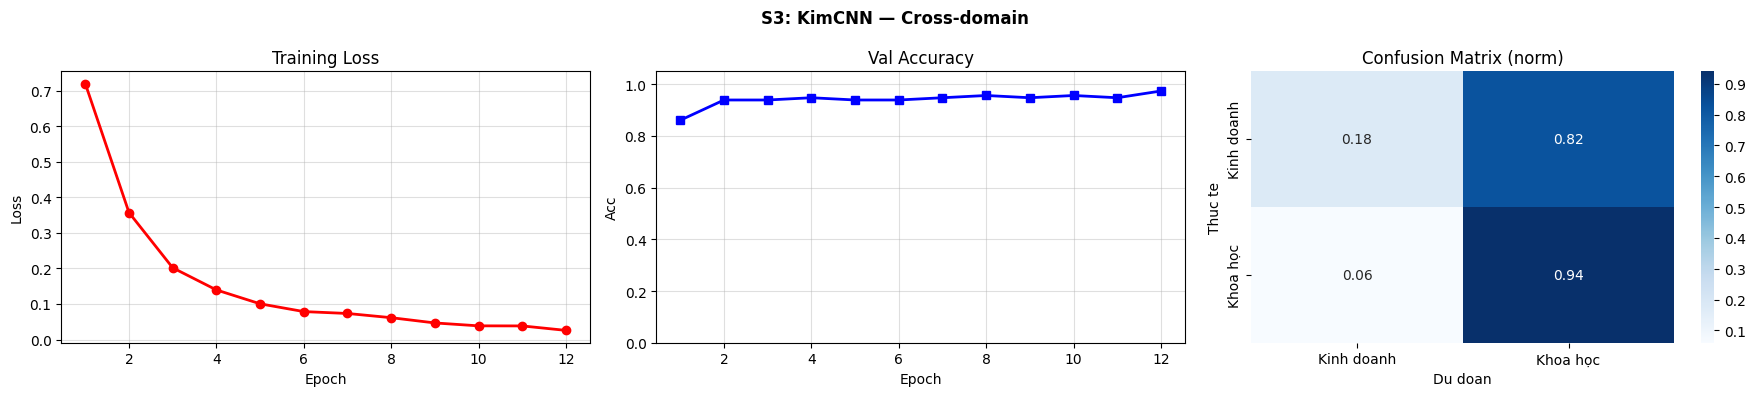

In [17]:
model_kimcnn = KimCNN(VOCAB_SIZE, EMBED_DIM, 100, [3,4,5], OUTPUT_DIM_CROSS, 0.5).to(device)
model_kimcnn, h, tp, tl = train_seq_model(
    model_kimcnn, trn_seq, val_seq, tst_seq,
    label_map_cross, "S3 — KimCNN (Cross-domain)", epochs=12)
acc, mf1, wf1 = print_metrics(tl, tp, label_map_cross, "S3 KimCNN")
results_s3['KimCNN'] = {'Accuracy': acc, 'Macro-F1': mf1, 'Weighted-F1': wf1}
plot_results(h, tp, tl, label_map_cross, "S3: KimCNN — Cross-domain", 'Blues')

### Cell 9 — BiLSTM + Attention


  S3 — BiLSTM+Attention (Cross-domain)
  Train=921 | Val=115 | Test=200
  Epoch 01 | Loss: 0.6727 | Val Acc: 0.8522
  Epoch 02 | Loss: 0.4784 | Val Acc: 0.8696
  Epoch 03 | Loss: 0.2999 | Val Acc: 0.9217
  Epoch 04 | Loss: 0.4679 | Val Acc: 0.8609
  Epoch 05 | Loss: 0.4487 | Val Acc: 0.7478
  Epoch 06 | Loss: 0.3755 | Val Acc: 0.8783
  Epoch 07 | Loss: 0.3488 | Val Acc: 0.8261
  Epoch 08 | Loss: 0.2562 | Val Acc: 0.9478
  Epoch 09 | Loss: 0.1677 | Val Acc: 0.9478
  Epoch 10 | Loss: 0.1314 | Val Acc: 0.9565

  Accuracy: 0.5350 | Macro-F1: 0.5341 | Weighted-F1: 0.5341
              precision    recall  f1-score   support

  Kinh doanh       0.53      0.58      0.56       100
    Khoa học       0.54      0.49      0.51       100

    accuracy                           0.54       200
   macro avg       0.54      0.53      0.53       200
weighted avg       0.54      0.54      0.53       200



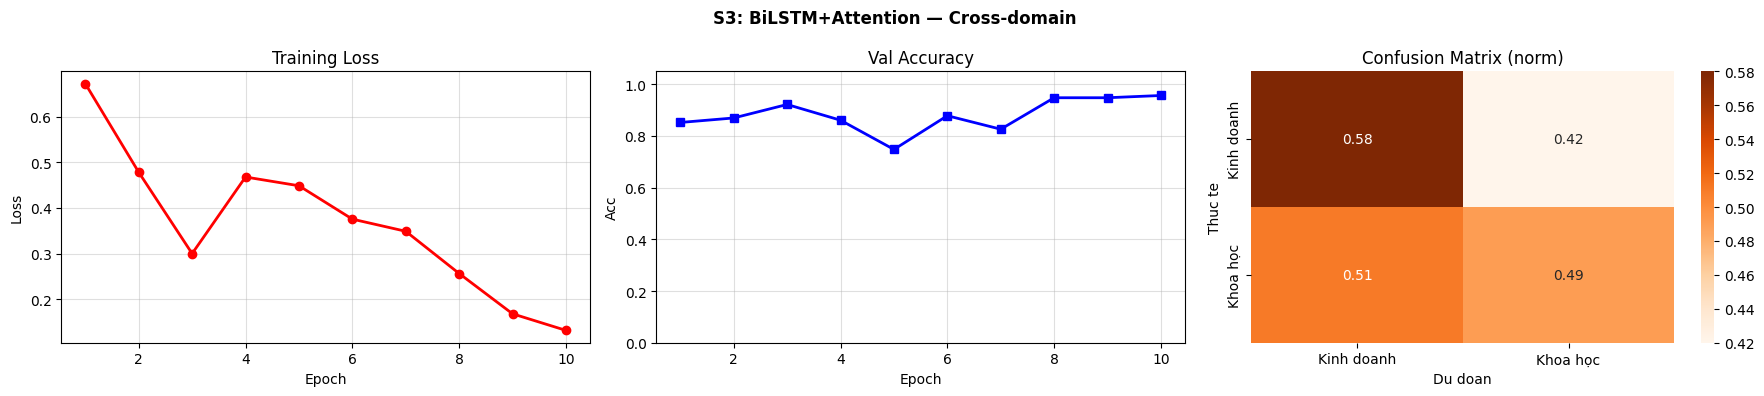

In [18]:
model_bilstm = BiLSTM_Attention(VOCAB_SIZE, EMBED_DIM, HIDDEN_DIM, OUTPUT_DIM_CROSS, 2, 0.5).to(device)
model_bilstm, h, tp, tl = train_seq_model(
    model_bilstm, trn_seq, val_seq, tst_seq,
    label_map_cross, "S3 — BiLSTM+Attention (Cross-domain)", epochs=10)
acc, mf1, wf1 = print_metrics(tl, tp, label_map_cross, "S3 BiLSTM+Attention")
results_s3['BiLSTM+Attn'] = {'Accuracy': acc, 'Macro-F1': mf1, 'Weighted-F1': wf1}
plot_results(h, tp, tl, label_map_cross, "S3: BiLSTM+Attention — Cross-domain", 'Oranges')

### Cell 10 — RCNN


  S3 — RCNN (Cross-domain)
  Train=921 | Val=115 | Test=200
  Epoch 01 | Loss: 0.6668 | Val Acc: 0.7652
  Epoch 02 | Loss: 0.4903 | Val Acc: 0.9391
  Epoch 03 | Loss: 0.2014 | Val Acc: 0.9130
  Epoch 04 | Loss: 0.0796 | Val Acc: 0.9043
  Epoch 05 | Loss: 0.0433 | Val Acc: 0.9652
  Epoch 06 | Loss: 0.0366 | Val Acc: 0.9565
  Epoch 07 | Loss: 0.0274 | Val Acc: 0.9478
  Epoch 08 | Loss: 0.0068 | Val Acc: 0.9739
  Epoch 09 | Loss: 0.0026 | Val Acc: 0.9739
  Epoch 10 | Loss: 0.0014 | Val Acc: 0.9652
  Epoch 11 | Loss: 0.0010 | Val Acc: 0.9652
  Epoch 12 | Loss: 0.0008 | Val Acc: 0.9739

  Accuracy: 0.5350 | Macro-F1: 0.4762 | Weighted-F1: 0.4762
              precision    recall  f1-score   support

  Kinh doanh       0.61      0.20      0.30       100
    Khoa học       0.52      0.87      0.65       100

    accuracy                           0.54       200
   macro avg       0.56      0.54      0.48       200
weighted avg       0.56      0.54      0.48       200



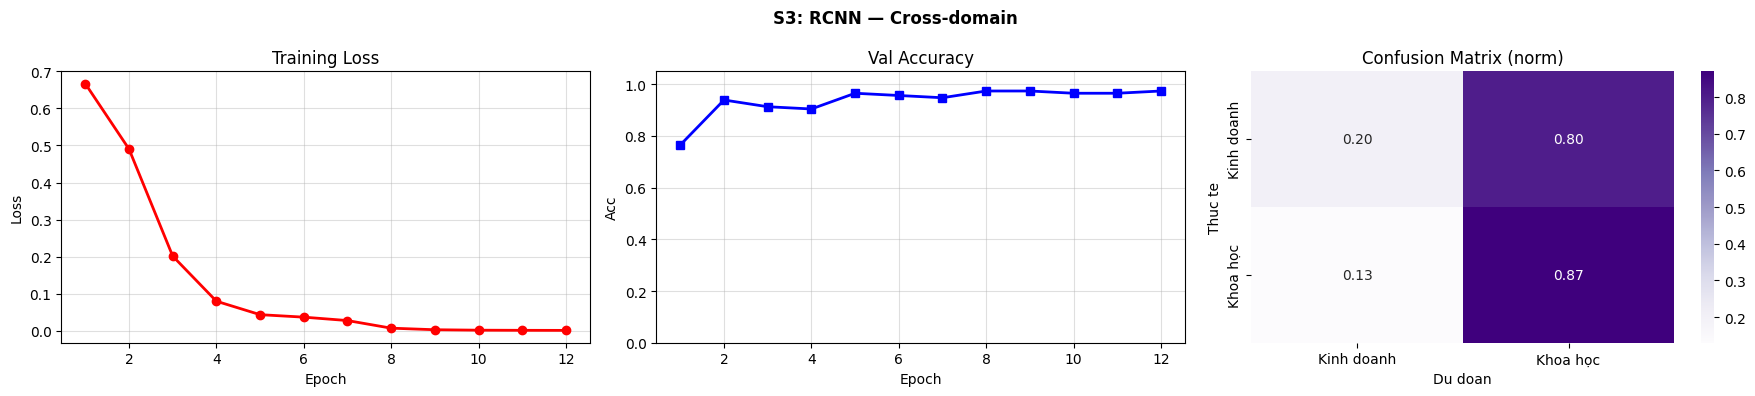

In [19]:
model_rcnn = RCNN(VOCAB_SIZE, EMBED_DIM, HIDDEN_DIM, OUTPUT_DIM_CROSS, 0.5).to(device)
model_rcnn, h, tp, tl = train_seq_model(
    model_rcnn, trn_seq, val_seq, tst_seq,
    label_map_cross, "S3 — RCNN (Cross-domain)", epochs=12)
acc, mf1, wf1 = print_metrics(tl, tp, label_map_cross, "S3 RCNN")
results_s3['RCNN'] = {'Accuracy': acc, 'Macro-F1': mf1, 'Weighted-F1': wf1}
plot_results(h, tp, tl, label_map_cross, "S3: RCNN — Cross-domain", 'Purples')

### Cell 11 — Transformer Encoder

In [10]:
model_trans = TransformerClassifier(VOCAB_SIZE, EMBED_DIM, 8, 256, 2, OUTPUT_DIM_CROSS, 0.5).to(device)
model_trans, h, tp, tl = train_seq_model(
    model_trans, trn_seq, val_seq, tst_seq,
    label_map_cross, "S3 — Transformer (Cross-domain)", epochs=12, lr=1e-4)
acc, mf1, wf1 = print_metrics(tl, tp, label_map_cross, "S3 Transformer")
results_s3['Transformer'] = {'Accuracy': acc, 'Macro-F1': mf1, 'Weighted-F1': wf1}
plot_results(h, tp, tl, label_map_cross, "S3: Transformer — Cross-domain", 'Greens')


  S3 — Transformer (Cross-domain)
  Train=921 | Val=115 | Test=200
  Epoch 01 | Loss: 0.6870 | Val Acc: 0.6348
  Epoch 02 | Loss: 0.6605 | Val Acc: 0.6696
  Epoch 03 | Loss: 0.6217 | Val Acc: 0.6696
  Epoch 04 | Loss: 0.5746 | Val Acc: 0.8000
  Epoch 05 | Loss: 0.4788 | Val Acc: 0.8696


KeyboardInterrupt: 

### Cell 12 — PhoBERT

In [ ]:
model_pho, h, tp, tl = train_pho_model(
    trn_pho, val_pho, tst_pho,
    label_map_cross, "S3 — PhoBERT (Cross-domain)", epochs=5)
acc, mf1, wf1 = print_metrics(tl, tp, label_map_cross, "S3 PhoBERT")
results_s3['PhoBERT'] = {'Accuracy': acc, 'Macro-F1': mf1, 'Weighted-F1': wf1}
plot_results(h, tp, tl, label_map_cross, "S3: PhoBERT — Cross-domain", 'YlOrRd')

pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/543M [00:00<?, ?B/s]

RobertaModel LOAD REPORT from: vinai/phobert-base
Key                             | Status     |  | 
--------------------------------+------------+--+-
lm_head.dense.weight            | UNEXPECTED |  | 
lm_head.decoder.bias            | UNEXPECTED |  | 
lm_head.decoder.weight          | UNEXPECTED |  | 
lm_head.layer_norm.bias         | UNEXPECTED |  | 
lm_head.layer_norm.weight       | UNEXPECTED |  | 
lm_head.dense.bias              | UNEXPECTED |  | 
lm_head.bias                    | UNEXPECTED |  | 
roberta.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.



  S3 — PhoBERT (Cross-domain)
  Train=921 | Val=115 | Test=200


## Cell 13 — Bảng Tổng Hợp & Gap Analysis

In [ ]:
df_s3 = pd.DataFrame(results_s3).T.reset_index().rename(columns={'index': 'Model'})
print("\n" + "="*60)
print("  KET QUA KICH BAN 3 — CROSS-DOMAIN (VnExpress -> NamSyntax)")
print("="*60)
print(df_s3.round(4).to_string(index=False))

# Bar chart
melted = df_s3.melt('Model', var_name='Metric', value_name='Score')
plt.figure(figsize=(13, 5))
ax = sns.barplot(data=melted, x='Model', y='Score', hue='Metric', palette='Set1')
for p in ax.patches:
    if p.get_height() > 0.01:
        ax.annotate(f'{p.get_height():.3f}',
                    (p.get_x() + p.get_width()/2, p.get_height()),
                    ha='center', va='bottom', fontsize=8)
plt.title('Kich Ban 3: Cross-domain (VnExpress -> NamSyntax)', fontsize=13, fontweight='bold')
plt.ylim(0, 1.15); plt.xticks(rotation=10); plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('s3_crossdomain_results.png', dpi=150, bbox_inches='tight')
plt.show()

# ── Gap Analysis — THAY Acc_S1 bằng kết quả thực Kịch bản 1 ─
Acc_S1 = {
    'KimCNN':      0.8850,   # <- thay số thực
    'BiLSTM+Attn': 0.7597,
    'RCNN':        0.9612,
    'Transformer': 0.9224,
    'PhoBERT':     0.9871,
}
print("\nCross-domain Gap (S1 In-domain  -  S3 Cross-domain):")
print("-"*50)
for row in df_s3.itertuples():
    in_acc = Acc_S1.get(row.Model, float('nan'))
    gap    = in_acc - row.Accuracy
    bar    = '|' * int(abs(gap) * 30)
    print(f"  {row.Model:<15} Gap = {gap:+.4f}  {bar}")
print("\nGap lon => domain shift manh. PhoBERT gap nho nhat => robust nhat.")